In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, LeaveOneOut, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [73]:
# Carregar dados
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Remover colunas desnecessárias
train = train.drop(columns=["id"], errors="ignore")
test = test.drop(columns=["id"], errors="ignore")

# Separar X e y
X = train.drop("satisfaction", axis=1)
y = train["satisfaction"].map({"neutral or dissatisfied": 0, "satisfied": 1})

# One-hot encoding
X = pd.get_dummies(X)
test = pd.get_dummies(test)

# Garantir alinhamento entre treino e teste
X, test = X.align(test, join="left", axis=1, fill_value=0)

# Substituir valores ausentes
X = X.fillna(0)
test = test.fillna(0)


In [74]:
# Divisão em treino e validação (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test)


In [ ]:
# Buscar o melhor valor de k
param_grid = {"n_neighbors": list(range(1, 31))}
knn = KNeighborsClassifier()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(knn, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_scaled, y_train)

best_k = grid.best_params_["n_neighbors"]
best_acc = grid.best_score_

print(f"✅ Melhor k encontrado: {best_k}")
print(f"📊 Acurácia média (5-Fold): {best_acc:.4f}")


In [ ]:
# Dicionário para armazenar resultados
resultados = []

# === 1️⃣ Hold-Out ===
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)
y_pred_val = knn.predict(X_val_scaled)
acc_holdout = accuracy_score(y_val, y_pred_val)
resultados.append(["Hold-Out", acc_holdout, 0.0])

# === 2️⃣ K-Fold ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores_kfold = cross_val_score(KNeighborsClassifier(n_neighbors=best_k),
                               X_train_scaled, y_train, cv=kf, scoring="accuracy")
resultados.append(["K-Fold", scores_kfold.mean(), scores_kfold.std()])

# === 3️⃣ Stratified K-Fold ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_strat = cross_val_score(KNeighborsClassifier(n_neighbors=best_k),
                               X_train_scaled, y_train, cv=skf, scoring="accuracy")
resultados.append(["Stratified K-Fold", scores_strat.mean(), scores_strat.std()])

# === 4️⃣ Leave-One-Out ===
subset = 1000  # usar subset para não travar
X_small = X_train_scaled[:subset]
y_small = y_train[:subset]

loo = LeaveOneOut()
scores_loo = cross_val_score(KNeighborsClassifier(n_neighbors=best_k),
                             X_small, y_small, cv=loo, scoring="accuracy")
resultados.append(["Leave-One-Out", scores_loo.mean(), scores_loo.std()])

# Converter para DataFrame
df_resultados = pd.DataFrame(resultados, columns=["Técnica", "Acurácia Média", "Desvio Padrão"])
display(df_resultados.round(4))


🎯 Acurácia Hold-Out (k=9): 0.9250


In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=df_resultados, x="Técnica", y="Acurácia Média", palette="viridis")

for i, row in df_resultados.iterrows():
    plt.errorbar(x=i, y=row["Acurácia Média"], yerr=row["Desvio Padrão"], fmt='none', c='black', capsize=5)

plt.title(f"Comparação das Técnicas de Treinamento (k={best_k})")
plt.ylabel("Acurácia Média")
plt.xlabel("Técnica")
plt.ylim(0.85, 0.95)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


📊 K-Fold (5 folds):
Acurácias: [0.921  0.9218 0.9225 0.9235 0.9227]
Média: 0.9223
Desvio padrão: 0.0009


⚖️ Stratified K-Fold (5 folds):
Acurácias: [0.9249 0.9263 0.918  0.9202 0.9233]
Média: 0.9225
Desvio padrão: 0.003


🧮 Leave-One-Out (com 1000 amostras, k=9):
Média: 0.884
Desvio padrão: 0.3202


🧮 Leave-One-Out (com 1000 amostras, k=9):
Média: 0.884
Desvio padrão: 0.3202


,Técnica,Acurácia Média,Desvio Padrão
0,Hold-Out,0.9250,0.0000
1,K-Fold,0.9223,0.0009
2,Stratified K-Fold,0.9225,0.0030
3,Leave-One-Out,0.8840,0.3202


C:\Users\jorge\AppData\Local\Temp\ipykernel_22952\3698051144.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resultados, x="Técnica", y="Acurácia Média", palette="viridis")


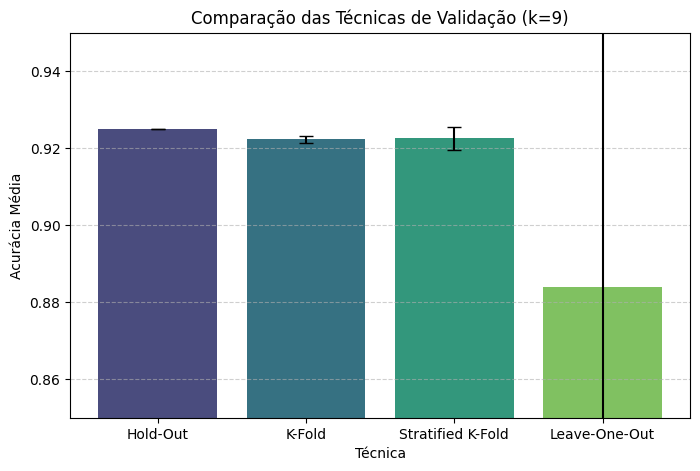

✅ Predições geradas e salvas em 'knn_predictions.csv'


,Predicted_satisfaction
0,satisfied
1,satisfied
2,neutral or dissatisfied
3,satisfied
4,neutral or dissatisfied


Verdadeiro Negativo (TN): 11331
Falso Positivo (FP): 445
Falso Negativo (FN): 1113
Verdadeiro Positivo (TP): 7892
Sensibilidade (Recall Satisfeito): 0.876
Especificidade (Recall Dissatisfeito): 0.962
